# Titanic: Machine Learning from Disaster

In [34]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import zero_one_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

## Chargement des données à disposition (Training et Test)

In [35]:
PATH= 'xxx'

# Chargement des données de training
x_train= pandas.read_csv(PATH+'train.csv', header=0)  
x_train["Sex"] = x_train["Sex"].astype("category")
x_train["Embarked"] = x_train["Embarked"].astype("category")

# Nous sommes en mode supervisé, donc on isole le vecteur "target"
y_train = x_train["Survived"]

# Chargement des données de test
x_test = pandas.read_csv(PATH+'test.csv', header=0)
x_test["Sex"] = x_test["Sex"].astype("category")
x_test["Embarked"] = x_test["Embarked"].astype("category")

Tracer la distribution de la variable "Survived"

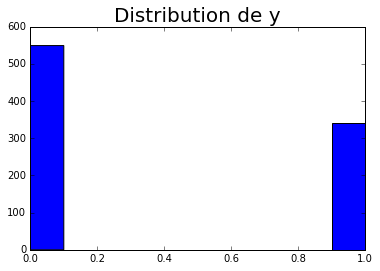

In [36]:
plt.hist(y_train)
plt.title("Distribution de y", fontsize=20)

Transformation des données catégorielles de chaînes de caractères en format numérique

In [37]:
x_train["Sex_num"] = x_train["Sex"].cat.codes
x_train["Embarked_num"] = x_train["Embarked"].cat.codes

In [38]:
x_test["Sex_num"] = x_test["Sex"].cat.codes
x_test["Embarked_num"] = x_test["Embarked"].cat.codes

Vérification du nombre de données manquantes

In [39]:
print("** Données de training : \n ")
print(x_train.isnull().sum(axis=0))

print("\n")
print("** Données de test : \n")
print(x_test.isnull().sum(axis=0))

** Données de training : 
 
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Sex_num           0
Embarked_num      0
dtype: int64


** Données de test : 

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Sex_num           0
Embarked_num      0
dtype: int64


Remplissage des valeurs manquantes pour la variable "EMbarked_num" par la valeur la plus représentée dans le jeu de données

In [40]:
x_train["Embarked_num"] = x_train["Embarked_num"].fillna(x_train.Embarked.mode())

Calculer la moyenne de l'âge par sexe afin de remplir les valeurs manquantes

In [41]:
x_train["Age"]= x_train.groupby("Sex").Age.transform(lambda x: x.fillna(int(x.mean())))
x_test["Age"]= x_test.groupby("Sex").Age.transform(lambda x: x.fillna(int(x.mean())))

Suppression des colonnes cabine et ticket n'apportant pas davantage d'informations 

In [42]:
x_train = x_train.drop(["Ticket","Cabin","PassengerId","Survived","Name"], axis=1)

In [43]:
x_train = x_train.drop(["Sex","Embarked"], axis=1)

In [44]:
x_train.tail()

,Pclass,Age,SibSp,Parch,Fare,Sex_num,Embarked_num
886,2,27,0,0,13.00,1,2
887,1,19,0,0,30.00,0,2
888,3,27,1,2,23.45,0,2
889,1,26,0,0,30.00,1,0
890,3,32,0,0,7.75,1,1


In [45]:
x_test['Fare'] = x_test.groupby(['Pclass','Embarked_num']).Fare.transform(lambda x: x.fillna(int(x.mean())))

In [46]:
x_test = x_test.drop(["Ticket","Cabin","PassengerId","Name","Sex","Embarked"], axis=1)

Séparation du dataset de training en 2 : un échantillon d'apprentissage et un échantillon de validation

In [48]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train,y_train,test_size=0.3)

Après avoir nettoyé les données, nous appliquons 3 algorithmes différents sur les données puis nous comparerons leurs performances à travers une courbe ROC.

### Algorithme 1 : Knn

In [47]:
# Définition d'une fonction de classification Knn permettant de sélectionner le meilleur k variant de 1 à 10.
# Cette fonction retourne le paramètre k optimal basé sur le score (0/1 loss) calculé
def knnClassifier(data,y):
    predicted = pandas.DataFrame({})
    scores = np.zeros((10,1))
    f1scores = np.zeros((10,1))
    clf = list()
    for n_neighbors in range(1,11):
        clf.append(None)
        clf[n_neighbors - 1] = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform",metric="manhattan",p=2)
        predicted[n_neighbors -1] = cross_val_predict(clf[n_neighbors - 1], data,y, cv=5)
        scores[n_neighbors - 1] = 1 - zero_one_loss(y,predicted[n_neighbors-1],normalize=True)
    kmax = scores.argmax() 
    print("K choisi : ",kmax," pour le score (0/1 loss) : ", scores[kmax -1])
    print("La matrice de confusion pour le meilleur k :\n",cm(y,predicted[kmax]))
    return kmax

In [49]:
k_opt = knnClassifier(x_train_1,y_train_1)

K choisi :  6  pour le score (0/1 loss) :  [ 0.71910112]
La matrice de confusion pour le meilleur k :
 [[305  73]
 [ 90 155]]


Calcul des probas de classification avec l'algorithme Knn avec le k optimal

In [50]:
clf_opt = neighbors.KNeighborsClassifier(k_opt, weights="uniform",metric="manhattan",p=2)
clf_opt = clf_opt.fit(x_train_1,y_train_1)
probas_knn = clf_opt.predict_proba(x_val)

### Algorithme 2 : Régression Logistique

In [52]:
clf_rl = LogisticRegression()
clf_rl = clf_rl.fit(x_train_1,y_train_1)

In [53]:
probas_rl = clf_rl.predict_proba(x_val)

### Algorithme 3 : Random Forest

In [54]:
forest = RandomForestClassifier(n_estimators=1000)
forest = forest.fit( x_train_1, y_train_1 )

In [55]:
probas_rf = forest.predict_proba(x_val)

### Remarque :
Il est possible d'améliorer les performances des 2 derniers algorithmes en faisant varier les paramètres avec un GridSearch qui permettra d'en sélectionner le meilleur

### Comparaison des 3 modèles utilisés grâce aux courbes ROC

AUC Knn : 0.749382
AUC RL : 0.819166
AUC RF : 0.835443


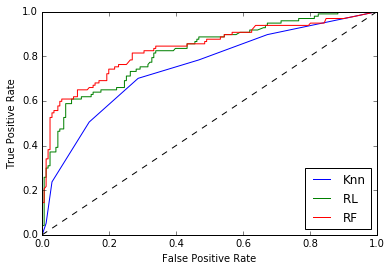

In [58]:
# probas est une matrice de deux colonnes avec la probabilités d'appartenance à chaque classe
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, probas_knn[:, 1])
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_val, probas_rl[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, probas_rf[:, 1])

plt.plot(fpr_knn, tpr_knn, label='Knn')
plt.plot(fpr_rl, tpr_rl, label='RL ')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

roc_auc_knn = auc(fpr_knn, tpr_knn)
print ("AUC Knn : %f" % roc_auc_knn)

roc_auc_rl = auc(fpr_rl, tpr_rl)
print ("AUC RL : %f" % roc_auc_rl)

roc_auc_rf = auc(fpr_rf, tpr_rf)
print ("AUC RF : %f" % roc_auc_rf)

Prédiction de survie sur l'échantillon de test avec le meilleur des classificateurs qui est le Random Forest

In [57]:
y_test = forest.predict(x_test)